输入navigation_log,图片序列

gps与相机的外参变换
数据从世界坐标（东北天）转换到相机坐标
时间戳同步

In [1]:
from __future__ import division
from __future__ import print_function

import argparse
import os  
import numpy as np
import copy
import string
from operator import itemgetter, attrgetter
from pyquaternion import Quaternion
import math
import matplotlib.pyplot as plt


In [2]:
def get_filename(path,filetype,name):
    for root,dirs,files in os.walk(path):
        for i in files:
            if filetype in i:
                name.append(i) 

读navigation_log.txt

odometry = (x, y, yaw)

gps = (x, y, z, yaw, state)

In [3]:
def read_navi_log(f_log):
    navi_log_output_list = []
    navi_log_input_list = []
    gps = []
    timeStamp = []
    odometry = []
    with open(f_log) as log_file:
        for line in log_file:
            segments = line.split(':')
            if segments[0] == 'navi_log_input_data':
                navi_log_input_list.append(map(float, segments[1].split()))
            elif segments[0] == 'navi_log_output_data':
                navi_log_output_list.append(map(float, segments[1].split()))
    navi_log_input = np.array(navi_log_input_list)
    navi_log_output = np.array(navi_log_output_list)

    print(navi_log_input.shape[0]," ",navi_log_output.shape[0])
    assert navi_log_input.shape[0] == navi_log_output.shape[0], "log input and output length do not equal!"
    data_length = navi_log_input.shape[0]
    for it in range(0,len(navi_log_input)):
        time_ = [navi_log_output[it][-1]]
        gps_ = [navi_log_input[it][17]+77000.0, navi_log_input[it][18]-4389000.0, 0.0, navi_log_input[it][19], navi_log_input[it][20]]
        #nav_output(odo+imu)
        odo_ = [navi_log_output[it][0]+77000.0, navi_log_output[it][1]-4389000.0, navi_log_output[it][-4]]
        gps.append(gps_)
        timeStamp.append(time_)
        odometry.append(odo_)
        
    
    return gps,odometry,timeStamp


读图

In [4]:
def read_img(f_im):
    sort_data = []
    name = []
    imageWithStamp = []
    get_filename(f_image,'.tiff',name)
    for image_name in name:
        sort_data.append((string.atof(image_name[0:17]),image_name))
        if(image_name[17] != '_'):
            print(image_name)
    imageWithStamp = sorted(sort_data, key=itemgetter(1))
    return imageWithStamp

image、gps(odometry)时间戳同步，线性插值，图片的帧率要低于gps(odometry)，delta：图片间隔

In [5]:
def Sys_data(gps,odometry,timeStamp,imageWithStamp,delta):
    last_image_time,last_odom,last_gps,last_time = 0.0, 0.0, 0.0, 0.0
    ODOM_SYS,GPS_SYS,GPS_WITH_IMAGE_SYS,IMAGE_KEY_SYS,TIMESTAMP_SYS = [],[],[],[],[]
    
    for im in range(0,len(imageWithStamp),delta):
        if(imageWithStamp[im][0] < timeStamp[0][0]):
            continue
        for io in range(0,len(timeStamp)):
            if(timeStamp[io][0] < last_image_time):
                continue
            if(timeStamp[io][0] < imageWithStamp[im][0]):
                last_odom = odometry[io]
                last_gps = gps[io]
                last_time = timeStamp[io]
            else:
    #           print(last_odom[0],odometry[io][0],imageWithStamp[im][0],last_time[0],timeStamp[io][0],last_time[0])
                # odometry x,y,theta
                x = last_odom[0]+(odometry[io][0]-last_odom[0])*(imageWithStamp[im][0] - last_time[0])/(timeStamp[io][0]-last_time[0])
                y = last_odom[1]+(odometry[io][1]-last_odom[1])*(imageWithStamp[im][0] - last_time[0])/(timeStamp[io][0]-last_time[0])
                if (odometry[io][2]-last_odom[2] > 0.5):
                    if(last_odom[2] < 0.1 and odometry[io][2] > 6.10):
                        odometry[io][2] = odometry[io][2] - 6.283
                    else:
                        print("odometry theta error : ",last_odom[2],"---->",odometry[io][2])
                        odometry[io][2] = last_odom[2]
                theta = last_odom[2]+(odometry[io][2]-last_odom[2])*(imageWithStamp[im][0] - last_time[0])/(timeStamp[io][0]-last_time[0])

                odom_sys = [x,y,theta]
                ODOM_SYS.append(odom_sys)
                #gps x,y,theta
                gps_x = last_gps[0]+(gps[io][0]-last_gps[0])*(imageWithStamp[im][0] - last_time[0])/(timeStamp[io][0]-last_time[0])
                gps_y = last_gps[1]+(gps[io][1]-last_gps[1])*(imageWithStamp[im][0] - last_time[0])/(timeStamp[io][0]-last_time[0])
                if(abs(gps[io][3] - last_gps[3]) > 3.0):
                    #0---->6.28
                    if(gps[io][3] > last_gps[3]):
                          gps[io][3] = gps[io][3]-2*math.pi
                    elif(gps[io][3] < last_gps[3]):
                        last_gps[3] = last_gps[3] -2*math.pi
                    else:
                        print("oh my god : ",last_gps[3],"---->",gps[io][3])       
                gps_yaw = last_gps[3] + (gps[io][3] - last_gps[3])*(imageWithStamp[im][0] - last_time[0])/(timeStamp[io][0]-last_time[0])
                if(gps_yaw<0):
                    gps_yaw += 2 * math.pi 
                #gps z 目前没有高度信息
                gps_state = (last_gps[4] + gps[io][4])/2
                gps_sys = [gps_x,gps_y,0.0,gps_yaw,gps_state]
                GPS_SYS.append(gps_sys)

                #用来check error使用,带索引的GPS数据
                gps_with_image_sys = [imageWithStamp[im][1],gps_x,gps_y,0.0,gps_yaw]
                GPS_WITH_IMAGE_SYS.append(gps_with_image_sys)
                #图片名
                image_key_sys = imageWithStamp[im][1]
                IMAGE_KEY_SYS.append(image_key_sys)
                #时间戳
                timestamp_sys = imageWithStamp[im][0]
                TIMESTAMP_SYS.append(timestamp_sys)

                last_image_time = imageWithStamp[im][0]
                break
    return ODOM_SYS,GPS_SYS,GPS_WITH_IMAGE_SYS,IMAGE_KEY_SYS,TIMESTAMP_SYS

将GPS数据转换到ORB_SLAM初始化决定的坐标系下:
$$(x,y,z,\theta)    \Rightarrow    (-y,-z,x,\theta_a)$$
$$if \ 0 < \theta < pi : \theta_a = - \theta$$
$$else : \ \theta_a = 2*pi -\theta $$


In [6]:
def world2slam(sys_time,sys_gps,sys_odom):
    SYS_GPS_L, SYS_ODOM_L = [] , []
    odomtry_in_matrix, gps_in_matrix = [], []
    for it in range(0,len(sys_time)):
        if(sys_gps[it][-2] < math.pi and sys_gps[it][-2] >= 0):
            gps = -sys_gps[it][-2]
            SYS_GPS_L.append(gps)
        elif(sys_gps[it][-2] >= math.pi and sys_gps[it][-2] <= math.pi*2):
            gps = math.pi*2 - sys_gps[it][-2]
            SYS_GPS_L.append(gps)
        else:
            print(sys_gps[it][-2])

        if(sys_odom[it][-1] < math.pi and sys_odom[it][-1] >= 0):
            odom = -sys_odom[it][-1]
            SYS_ODOM_L.append(odom) 
        elif(sys_odom[it][-1] >= math.pi and sys_odom[it][-1] <= math.pi*2):
            odom = math.pi*2 - sys_odom[it][-1]
            SYS_ODOM_L.append(odom)
        else:
            print(sys_odom[it][-1])
            continue   
        it_quaternion_odometry = Quaternion(axis=[0,1,0],angle = odom)
        it_quaternion_gps = Quaternion(axis=[0,1,0],angle = gps)

        odo_pose = [it_quaternion_odometry.rotation_matrix[0][0],it_quaternion_odometry.rotation_matrix[0][1],it_quaternion_odometry.rotation_matrix[0][2],-sys_odom[it][1],\
                    it_quaternion_odometry.rotation_matrix[1][0],it_quaternion_odometry.rotation_matrix[1][1],it_quaternion_odometry.rotation_matrix[1][2],0.0,\
                    it_quaternion_odometry.rotation_matrix[2][0],it_quaternion_odometry.rotation_matrix[2][1],it_quaternion_odometry.rotation_matrix[2][2],sys_odom[it][0]]
        gps_pose = [it_quaternion_gps.rotation_matrix[0][0],it_quaternion_gps.rotation_matrix[0][1],it_quaternion_gps.rotation_matrix[0][2],-sys_gps[it][1],\
                    it_quaternion_gps.rotation_matrix[1][0],it_quaternion_gps.rotation_matrix[1][1],it_quaternion_gps.rotation_matrix[1][2],0.0,\
                    it_quaternion_gps.rotation_matrix[2][0],it_quaternion_gps.rotation_matrix[2][1],it_quaternion_gps.rotation_matrix[2][2],sys_gps[it][0],\
                    sys_gps[it][-1]]
        odomtry_in_matrix.append(odo_pose)
        gps_in_matrix.append(gps_pose)
    return SYS_GPS_L, SYS_ODOM_L,odomtry_in_matrix, gps_in_matrix

gps--->camera外参偏移转换
$$x = x_0 + vertical * cos(\theta)$$
$$y = y_0 + vertical * sin(\theta)$$

In [7]:
# for i in Sys_GPS:
# #     print('gps_frame',i[0],i[1],i[3])
#     i[0] = i[0] + camera_to_vehicle_vertical*math.cos(i[3])
#     i[1] = i[1] + camera_to_vehicle_vertical*math.sin(i[3])
#     print('cam_frame',i[0],i[1],i[3])
#     p=input()

23815   23815


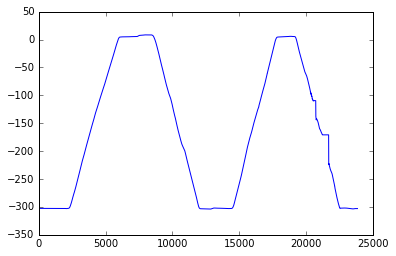

In [8]:
filename = '/home/jianc/dataset/fangshan0'
f_nav = filename+'/uos_navigation.log'
f_image = filename+'/dump_images/image_capturer_0'


camera_to_vehicle_horizontal = 0.0
camera_to_vehicle_vertical = 1.05
Ry_cam_to_veh = -1.0


nav_gps,nav_odom,nav_timestamp = read_navi_log(f_nav)

# tmp = []
# for i in nav_gps:
#     tmp.append(i[0])

# plt.plot(tmp)


# image = read_img(f_image)
# delta = 2
# # print(read_navi_log(f_nav)[0][0])
# # print(read_img(f_image)[0])
# last_image_time,last_odom,last_gps,last_time = 0.0,0.0,0.0,0.0
# odometry,gps,gps_image,image_key,time_stamp = Sys_data(nav_gps,nav_odom,nav_timestamp,image,2)
# # plot(odometry,gps)
# SYS_GPS_L, SYS_ODOM_L,odomtry_in_matrix, gps_in_matrix = world2slam(time_stamp,gps,odometry)


写文件

建图需要gps.txt odom.txt image_name.txt times.txt

In [9]:
g = open(filename+"/dump_images/gps.txt","w")
for i in gps_in_matrix:
    print(i[0],i[1],i[2],i[3],i[4],i[5],i[6],i[7],i[8],i[9],i[10],i[11],i[12],file = g)
g.close()

In [10]:
o = open(filename+"/dump_images/odom.txt","w")
for i in odomtry_in_matrix:
    print(i[0],i[1],i[2],i[3],i[4],i[5],i[6],i[7],i[8],i[9],i[10],i[11],file = o)
o.close()

In [11]:
t = open(filename+"/dump_images/image_name.txt","w")
for i in image_key:
    print(i,file = t)
t.close()

In [12]:
time = open(filename+"/dump_images/times.txt","w")
for i in time_stamp:
    print(i,file=time)
time.close()

vtracker需要img_name.txt（绝对路径）

In [13]:
img_name = open(filename+"/dump_images/imgname.txt","w")
for i in image_key:
    print(filename+"/dump_images/image_capturer_0/"+i,file = img_name)
img_name.close()

对比需要gps_images.txt（原始数据)

In [14]:
gps_im = open(filename+"/dump_images/gps_imagekey.txt","w")
for i in gps_image:
    print(i[0],i[1],i[2],i[3],i[4],file=gps_im)
gps_im.close()

In [15]:
print('done')

done
